In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno_interp import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(),
               LossTracker(),SaveBest('weights/best_ii2.h5'),EarlyStopping(10)])

In [ ]:
model.save('weights/Inferno_Test_interp_bm2.h5')

In [7]:
model.load('weights/Inferno_Test_interp_bm2.h5')

# Results

## BM 0

In [8]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [9]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,6,1.0
1,6,1.0
2,2,1.0
3,6,1.0
4,6,1.0


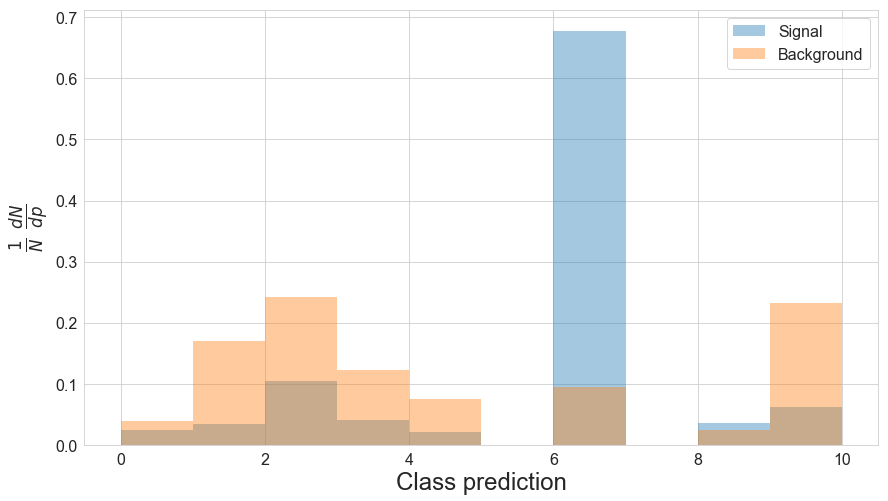

In [10]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [11]:
bin_preds(df)

In [12]:
df.head()

,pred,gen_target,pred_bin
0,6,1.0,6
1,6,1.0,6
2,2,1.0,2
3,6,1.0,6
4,6,1.0,6


In [13]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [14]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [15]:
f_s, f_b

(tensor([2.5052e-02, 3.3484e-02, 1.0410e-01, 4.0404e-02, 2.1496e-02, 2.0000e-13,
         6.7829e-01, 2.0000e-13, 3.5928e-02, 6.1244e-02]),
 tensor([3.9648e-02, 1.7023e-01, 2.4257e-01, 1.2223e-01, 7.4580e-02, 2.0000e-13,
         9.4698e-02, 2.0000e-13, 2.3748e-02, 2.3231e-01]))

In [16]:
asimov = (50*f_s)+(1000*f_b)

In [17]:
asimov, asimov.sum()

(tensor([4.0901e+01, 1.7190e+02, 2.4777e+02, 1.2425e+02, 7.5655e+01, 2.1000e-10,
         1.2861e+02, 2.1000e-10, 2.5544e+01, 2.3537e+02]), tensor(1050.))

In [18]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([27.77069855, 27.64121246, 27.51687622, 27.39766693, 27.28313065,
       27.17406082, 27.06957245, 26.96987915, 26.8751297 , 26.78517914,
       26.69976425, 26.61885452, 26.54280853, 26.47108459, 26.40395355,
       26.34109497, 26.28301239, 26.22868729, 26.17905045, 26.13343048,
       26.09226227, 26.05482483, 26.02138519, 25.99259567, 25.96741867,
       25.94644165, 25.92927551, 25.91589355, 25.90659332, 25.90094757,
       25.89901352, 25.9006958 , 25.90632629, 25.91571045, 25.92850494,
       25.94477844, 25.96483994, 25.98838425, 26.01514435, 26.04559326,
       26.07948303, 26.11652374, 26.15697479, 26.20088577, 26.24817657,
       26.29828644, 26.3518219 , 26.40862274, 26.46851349, 26.53154373,
       26.59777451, 26.6672287 , 26.73923492, 26.81458282, 26.89293671,
       26.97422791, 27.05830002, 27.14559937, 27.23547363, 27.32823181,
       27.42404938])

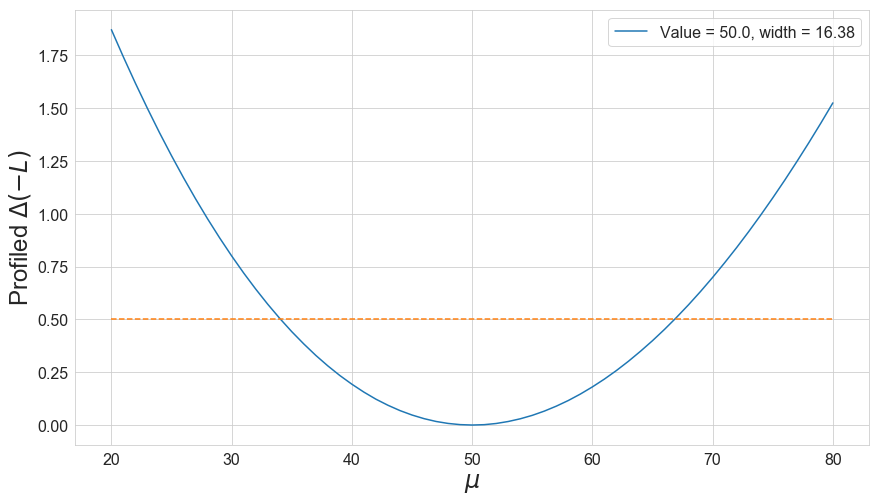

In [21]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [23]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [24]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [25]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,6,1.0,6,6,6,6,6,6,6,6,6,6,6
1,6,1.0,6,6,6,6,6,6,6,6,6,6,6
2,2,1.0,2,2,2,2,2,2,2,2,2,2,2
3,6,1.0,6,6,6,6,6,6,6,6,6,6,6
4,6,1.0,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2,0.0,2,2,2,2,2,2,2,2,2,2,2
999996,2,0.0,2,3,3,2,2,2,2,2,2,3,3
999997,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999998,8,0.0,8,4,4,8,8,6,6,8,8,8,8


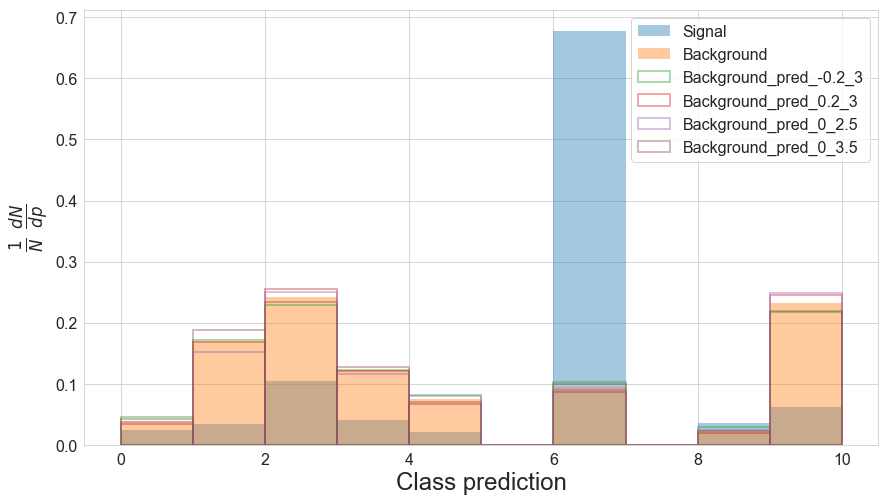

In [26]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([4.3646e-02, 1.5344e-01, 2.3788e-01, 1.1595e-01, 8.6738e-02, 2.0000e-13,
        9.8076e-02, 2.0000e-13, 2.8836e-02, 2.3544e-01])
tensor([4.5920e-02, 1.7120e-01, 2.2938e-01, 1.2175e-01, 8.2036e-02, 2.0000e-13,
        1.0266e-01, 2.0000e-13, 2.8404e-02, 2.1865e-01])
tensor([4.7958e-02, 1.8865e-01, 2.2038e-01, 1.2631e-01, 7.7672e-02, 2.0000e-13,
        1.0728e-01, 2.0000e-13, 2.8000e-02, 2.0375e-01])
tensor([3.7374e-02, 1.5247e-01, 2.5106e-01, 1.1643e-01, 7.9282e-02, 2.0000e-13,
        9.0114e-02, 2.0000e-13, 2.4180e-02, 2.4910e-01])
tensor([3.9648e-02, 1.7023e-01, 2.4257e-01, 1.2223e-01, 7.4580e-02, 2.0000e-13,
        9.4698e-02, 2.0000e-13, 2.3748e-02, 2.3231e-01])
tensor([4.1686e-02, 1.8768e-01, 2.3356e-01, 1.2679e-01, 7.0216e-02, 2.0000e-13,
        9.9316e-02, 2.0000e-13, 2.3344e-02, 2.1740e-01])
tensor([3.2172e-02, 1.5077e-01, 2.6423e-01, 1.1570e-01, 7.2108e-02, 2.0000e-13,
        8.2242e-02, 2.0000e-13, 2.0126e-02, 2.6265e-01])
tensor([3.4446e-02, 1.6853e-01, 2.5574e-0

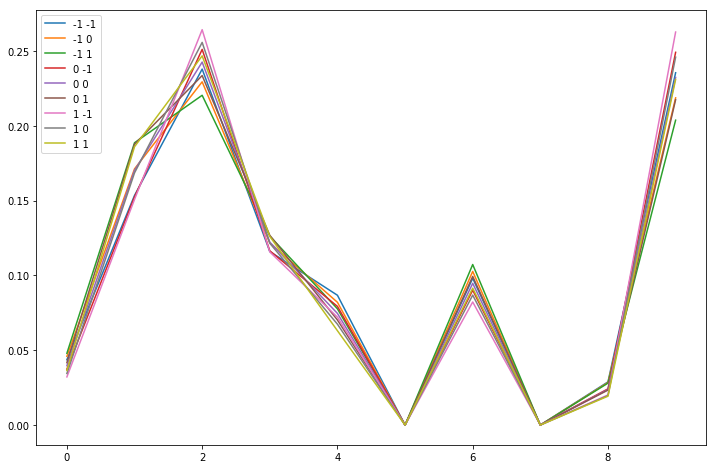

In [27]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [28]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [29]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [30]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [31]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [32]:
nll = to_np(nll)

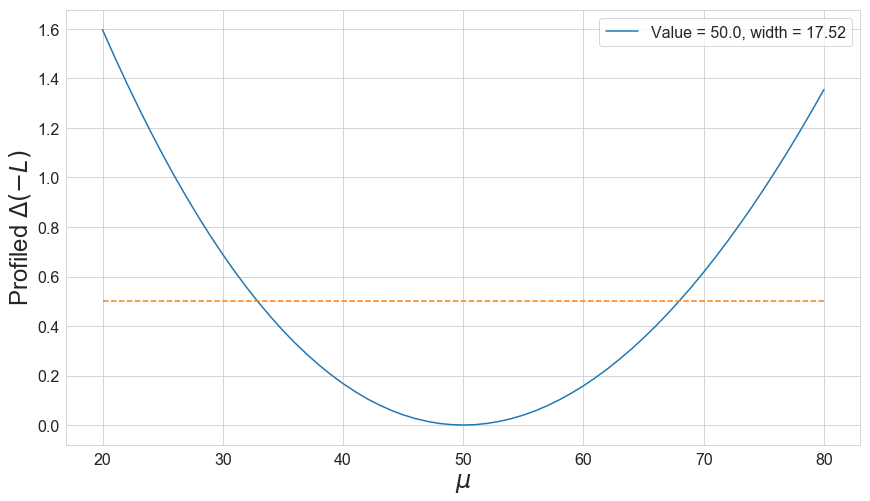

In [33]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [34]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [35]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [36]:
nll = to_np(nll)

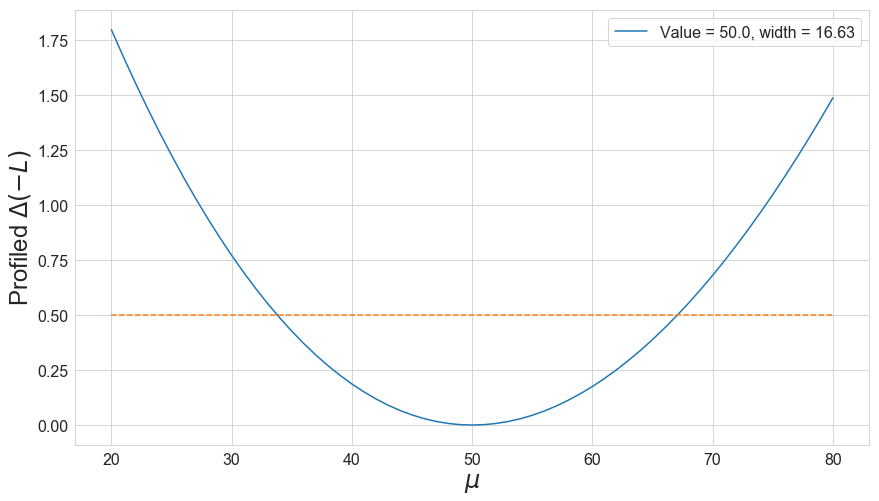

In [37]:
plot_likelihood(nll-nll.min())

## BM 2

In [38]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [39]:
nll = to_np(nll)

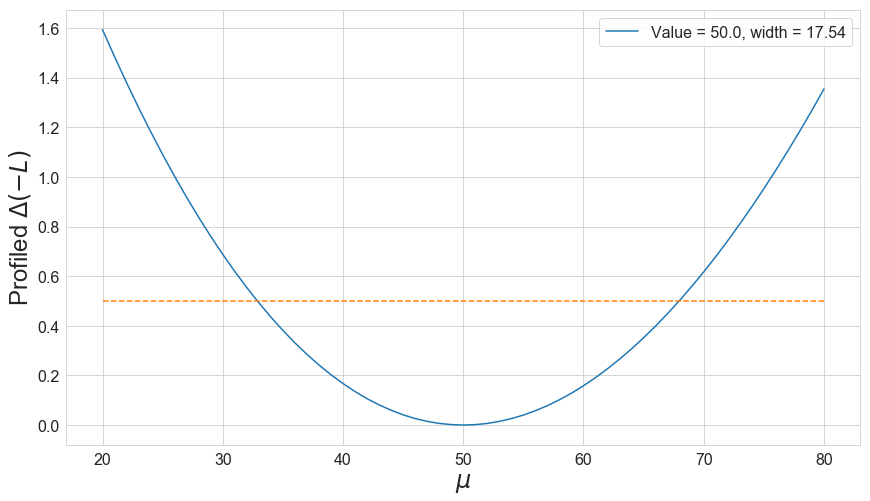

In [40]:
plot_likelihood(nll-nll.min())

## BM 3

In [41]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [42]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [43]:
nll = to_np(nll)

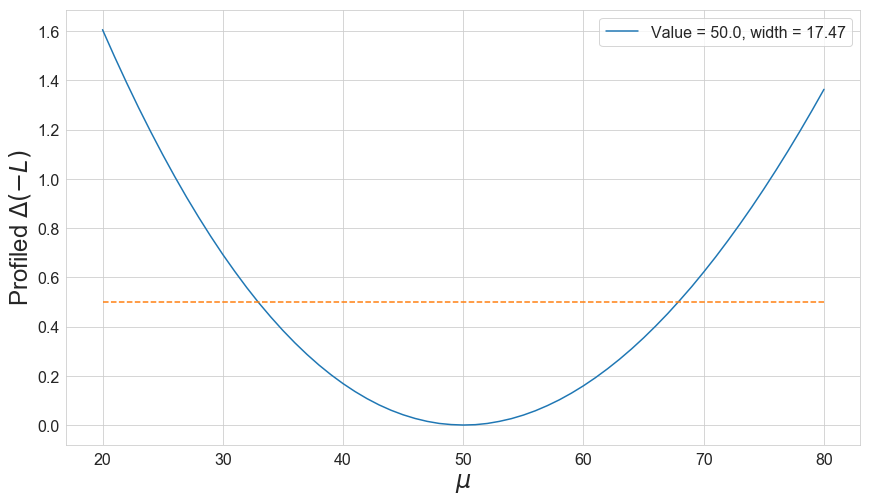

In [44]:
plot_likelihood(nll-nll.min())

## BM 4

In [45]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [46]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3145,  0.0538, 25.6459])
Linear regime: Mu 21.0, alpha tensor([-0.3033,  0.0517, 24.7225])
Linear regime: Mu 22.0, alpha tensor([-0.2922,  0.0496, 23.8043])
Linear regime: Mu 23.0, alpha tensor([-0.2812,  0.0475, 22.8912])
Linear regime: Mu 24.0, alpha tensor([-0.2702,  0.0454, 21.9831])
Linear regime: Mu 25.0, alpha tensor([-0.2592,  0.0434, 21.0800])
Linear regime: Mu 26.0, alpha tensor([-0.2483,  0.0414, 20.1819])
Linear regime: Mu 27.0, alpha tensor([-0.2374,  0.0394, 19.2887])
Linear regime: Mu 28.0, alpha tensor([-0.2266,  0.0374, 18.4004])
Linear regime: Mu 29.0, alpha tensor([-0.2159,  0.0354, 17.5168])
Linear regime: Mu 30.0, alpha tensor([-0.2051,  0.0335, 16.6381])
Linear regime: Mu 31.0, alpha tensor([-0.1944,  0.0316, 15.7641])
Linear regime: Mu 32.0, alpha tensor([-0.1838,  0.0298, 14.8948])
Linear regime: Mu 33.0, alpha tensor([-0.1732,  0.0279, 14.0301])
Linear regime: Mu 34.0, alpha tensor([-0.1627,  0.0261, 13.1700])
Linear reg

In [47]:
nll = to_np(nll)

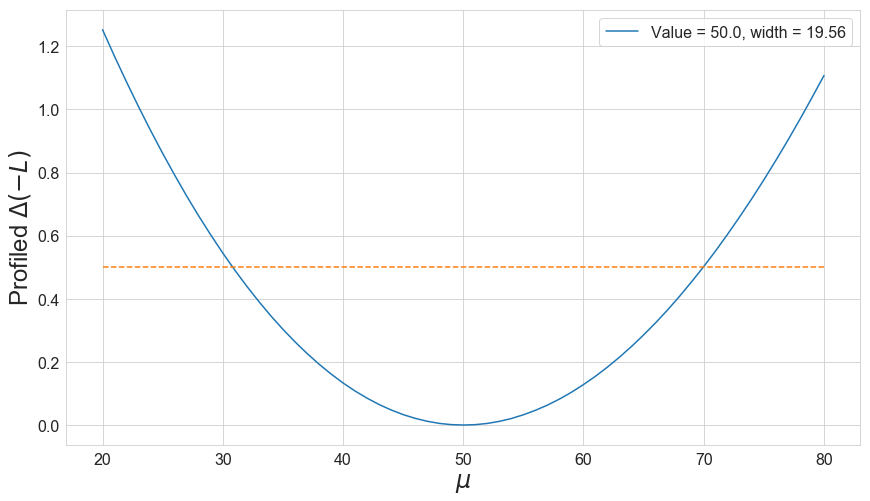

In [48]:
plot_likelihood(nll-nll.min())